# IMOS/AODN SAR Wind: Getting Started

## Example of Australian coastal SAR winds compared to regional and global reanalyses winds

**AODN Assistance** - info at aodn.org.au

2024-04-24

This script is used to read the Aus SAR winds dataset

|  |  |
| ----------- | ----------- |
| Author:| Salman Khan |
| Edited:| Benjamin Stepin |
| Affiliation:| CSIRO, IMOS |
| e-mail:| salmansaeed.khan@csiro.au, info@aodn.org.au |
| Date of creation:| 18th Nov., 2021 |
| Date of last update:| 29th Apr., 2024 |


## Table of contents

### [Background](#background-what)
### [Required Packages](#required)
1. [Useful Functions](#functions)
2. [Open SAR wind datasets for a swath over Tasmania](#open-sar)
3. [Open BARRA (Bureau of meteorology Atmospheric high-resolution Regional Reanalysis for Australia) 10m mean winds at nearest time](#open-barra)
4. [Open ERA5 10m mean hourly winds at nearest time](#open-era5)
5. [Set contour colors, levels, land color etc.](#contour)
6. [Plot SAR, BARRA-Tas, BARRA-R, and ERA5 matching wind fields](#plot-sar)

## Background: About Sentinel-1 Ocean Surface Wave Measurements <a name="background-what"></a>

The IMOS Surface Waves sub-Facility, which is operated by CSIRO in partnership with University of Melbourne, have just published a new wind data collection in the AODN Portal.

The new collection is a km-resolution ocean wind speed and direction database over coastal seas of Australia, New Zealand, Western Pacific islands, and the Maritime continent. It is obtained from Europe’s Copernicus Sentinel-1 A and B Synthetic Aperture Radar (SAR) satellites from 2017 up till present. The files are accessible through [AODN s3 Explorer](https://data.aodn.org.au/?prefix=IMOS/SRS/Surface-Waves/) [or THREDDS server](https://thredds.aodn.org.au/thredds/catalog/IMOS/SRS/Surface-Waves/catalog.html).

A SAR is a microwave radar sensor used to measure the reflection or scattering effect produced while imaging the surface of the earth in high resolution from an aircraft or a satellite. It can record measurements even at night, during cloud cover, and in most weather conditions.

Wind measurements by SAR go all the way up to the coast due to its high resolution, filling critical gaps in ocean wind speed and direction observations in coastal areas.

SAR ocean wind measurements are calibrated and validated against overlaps with offshore Scatterometer and Altimeter wind measurements. Both Scatterometer and Altimeter Ocean winds are already carefully calibrated against ocean buoys.

The new collection is a first of its kind in the region and captures the spatial variability of coastal ocean winds over a wide swath (250 km). SAR measurements over strong wind events, including tropical cyclones, reveals new insights into the structure of extreme wind fields.

These data are useful for offshore industry (oil and gas, fisheries, shipping, offshore wind), protection and management of coasts, habitats, and infrastructure, capturing of sub-mesoscale air-sea interactions, and improvement of forcing in numerical models.

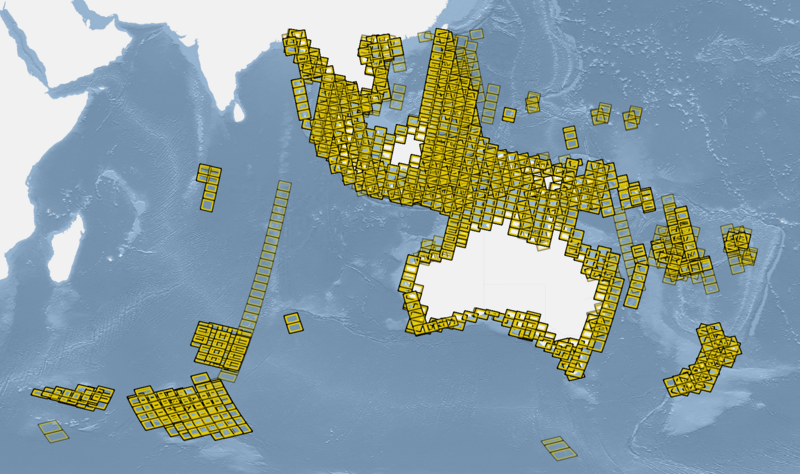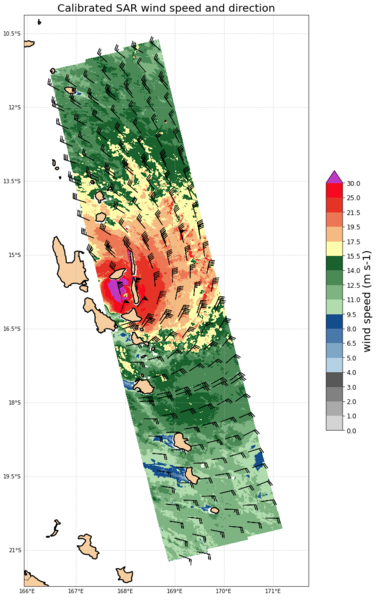


## Required packages <a name="required"></a>

- Python 3.10.13
- Cartopy==0.23.0
- matplotlib==3.8.4
- numpy==1.26.4
- xarray==2024.3.0
- NetCDF4
- PyDap

In [1]:
# Run the following to install required packages
# !pip install Cartopy==0.23.0 matplotlib==3.8.4 numpy==1.26.4 xarray==2024.3.0 NetCDF4 PyDap


In [2]:
%reset -f    
import os, glob
import sys    
import cartopy as cart
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

## 1. Useful functions <a name="functions"></a>


In [3]:
def savefig(fig, filename, dpi = 300):
    """Save a fig with 0 padding.
       Args:
           - fig (matplotlib.figure.Figure): a figure object
           - filename (str): path and filename to save
    """
    try:
        fig.savefig(filename, bbox_inches = 'tight', pad_inches = 0.1, dpi = dpi)
    except:
        sys.exit('Figure: {0:s} could not be saved.'.format(filename))
        
def met2math(wdir_met):
    '''
    meteorological wdir is the from direction rel. to North
    '''
    return (270. - wdir_met)  % 360.

def to_uv(ws, phi):
    '''
    Here phi needs to be the math angle of wind
    relative to east and positive anti-clockwise
    can be 0-360 or +-180, I think it doesn't matter
    as the function internally handles it
    e.g. to_uv(10, -45) == to_uv(10, 360-45)
    or.  to_uv(10, -90) == to_uv(10, 270)
    '''
    u = ws * np.cos(np.deg2rad(phi))
    v = ws * np.sin(np.deg2rad(phi))
    return u, v
from matplotlib.colors import ListedColormap, BoundaryNorm

def discretecmap(cmin, cmax, cmap):
    """ Creates a discrete Colormap within desired bounds
    Args:
        - cmin (int): minimum color
        - cmax (int): maximum color
        - cmap (matplotlib.colors.Colormap): a Colormap object            
    Returns:
        - norm (matplotlib.colors.BoundaryNorm): a BoundaryNorm object
    """
    bounds = np.linspace(cmin, cmax, cmax - cmin + 1)
    return BoundaryNorm(bounds, cmap.N)    


## 2. Open SAR wind datasets for a swath over Tasmania <a name="open-sar"></a>
swath time is roughly about 2018-04-14T19:25:00Z

In [4]:
opendap_links = ['https://thredds.aodn.org.au/thredds/dodsC/IMOS/SRS/Surface-Waves/SAR_Wind/DELAYED/SENTINEL-1A/2018/04/14/IMOS_SRS-Surface-Waves_M_20180414_Coastal-Wind-Sentinel-1A_FV01_DM00-021467-024F96-0798.nc',
 'https://thredds.aodn.org.au/thredds/dodsC/IMOS/SRS/Surface-Waves/SAR_Wind/DELAYED/SENTINEL-1A/2018/04/14/IMOS_SRS-Surface-Waves_M_20180414_Coastal-Wind-Sentinel-1A_FV01_DM00-021467-024F96-8040.nc', 
 'https://thredds.aodn.org.au/thredds/dodsC/IMOS/SRS/Surface-Waves/SAR_Wind/DELAYED/SENTINEL-1A/2018/04/14/IMOS_SRS-Surface-Waves_M_20180414_Coastal-Wind-Sentinel-1A_FV01_DM00-021467-024F96-C23A.nc']
dset_list = [xr.open_dataset(odlink) for odlink in sorted(opendap_links)]


## 3. Open BARRA (Bureau of meteorology Atmospheric high-resolution Regional Reanalysis for Australia) 10m mean winds at nearest time <a name="open-barra"></a>

- Regional (12 km)
- Tasmanian (1.5 km)

In [5]:
uwnd_r_opendap = 'https://dapds00.nci.org.au/thredds/dodsC/cj37/BARRA/BARRA_R/v1/forecast/slv/av_uwnd10m/2018/04/av_uwnd10m-fc-slv-PT1H-BARRA_R-v1-20180414T1800Z.sub.nc'
vwnd_r_opendap = 'https://dapds00.nci.org.au/thredds/dodsC/cj37/BARRA/BARRA_R/v1/forecast/slv/av_vwnd10m/2018/04/av_vwnd10m-fc-slv-PT1H-BARRA_R-v1-20180414T1800Z.sub.nc'
uwnd_ta_opendap = 'https://dapds00.nci.org.au/thredds/dodsC/cj37/BARRA/BARRA_TA/v1/forecast/slv/av_uwnd10m/2018/04/av_uwnd10m-fc-slv-PT1H-BARRA_TA-v1-20180414T1200Z.sub.nc'
vwnd_ta_opendap = 'https://dapds00.nci.org.au/thredds/dodsC/cj37/BARRA/BARRA_TA/v1/forecast/slv/av_vwnd10m/2018/04/av_vwnd10m-fc-slv-PT1H-BARRA_TA-v1-20180414T1200Z.sub.nc'

# select matching time 2018-04-14T19:30:00
uwnd_r = xr.open_dataset(uwnd_r_opendap)['av_uwnd10m'].isel(time = 1)
vwnd_r = xr.open_dataset(vwnd_r_opendap)['av_vwnd10m'].isel(time = 1)
uwnd_ta = xr.open_dataset(uwnd_ta_opendap)['av_uwnd10m'].isel(time = 4)
vwnd_ta = xr.open_dataset(vwnd_ta_opendap)['av_vwnd10m'].isel(time = 4)

# interpolate uwnd on vwnd grid
uwnd_r = uwnd_r.interp(latitude = vwnd_r['latitude'], longitude = vwnd_r['longitude'])
uwnd_ta = uwnd_ta.interp(latitude = vwnd_ta['latitude'], longitude = vwnd_ta['longitude'])


## 4. Open ERA5 10m mean hourly winds at nearest time <a name="open-era5"></a>
0.25 deg horizontal resolution

In this part we are using the xarray open dataset functionality to extrac a particular part of the NetCDF file. This url can be updated for a different wind dataset from the thredds server.

In [6]:
dap_url = "https://thredds.rda.ucar.edu/thredds/dodsC/files/g/ds633.0/e5.oper.an.sfc/201804/e5.oper.an.sfc.228_131_u10n.ll025sc.2018040100_2018043023.nc"
ds = xr.open_dataset(dap_url)

# select matching time 2018-04-14T19:00:00
u10_era5 = ds.sel(time = '2018-04-14T19:00:00')['U10N']


dap_url = "https://thredds.rda.ucar.edu/thredds/dodsC/files/g/ds633.0/e5.oper.an.sfc/201804/e5.oper.an.sfc.228_132_v10n.ll025sc.2018040100_2018043023.nc"
ds = xr.open_dataset(dap_url)

v10_era5 = ds.sel(time = '2018-04-14T19:00:00')['V10N']

## 5. Set contour colors, levels, land color etc. <a name="contour"></a>


In [7]:
contour_clrs = np.array(([212, 212, 212],
                      [170,170,170],
                      [129,129,129],
                      [88,88,88],
                      [181,209,228],
                      [127,165,199],
                      [73,121,170],
                      [20, 77, 141],
                      [177, 220, 173],
                      [126,179,130],
                      [75,138,87],
                      [25,97, 45],
                      [254, 253, 174],
                      [245,186,129],
                      [237,119,84],
                      [229, 52, 39],
                      [246, 10, 29],
                      [190, 57, 194]))/255.0
levels = np.array((0, 1, 2, 3, 4, 5, 6.5, 8, 9.5, 11, 12.5, 14, 15.5, 17.5, 19.5, 21.5, 25, 30))
land_clr = (247/255, 206/255, 160/255)
mps2knots = 1.944

## 6. Plot SAR, BARRA-Tas, BARRA-R, and ERA5 matching wind fields <a name="plot-sar"></a>


In [8]:
extent = (143, 148.5, -37.55, -44)
uwnd_r = uwnd_r.sel(longitude = slice(143, 148.5), latitude = slice(-44, -37.55))
vwnd_r = vwnd_r.sel(longitude = slice(143, 148.5), latitude = slice(-44, -37.55))
uwnd_ta = uwnd_ta.sel(longitude = slice(143, 148.5), latitude = slice(-44, -37.55))
vwnd_ta = vwnd_ta.sel(longitude = slice(143, 148.5), latitude = slice(-44, -37.55))
u10_era5 = u10_era5.sel(longitude = slice(143, 148.5), latitude = slice(-37.55, -44))
v10_era5 = v10_era5.sel(longitude = slice(143, 148.5), latitude = slice(-37.55, -44))

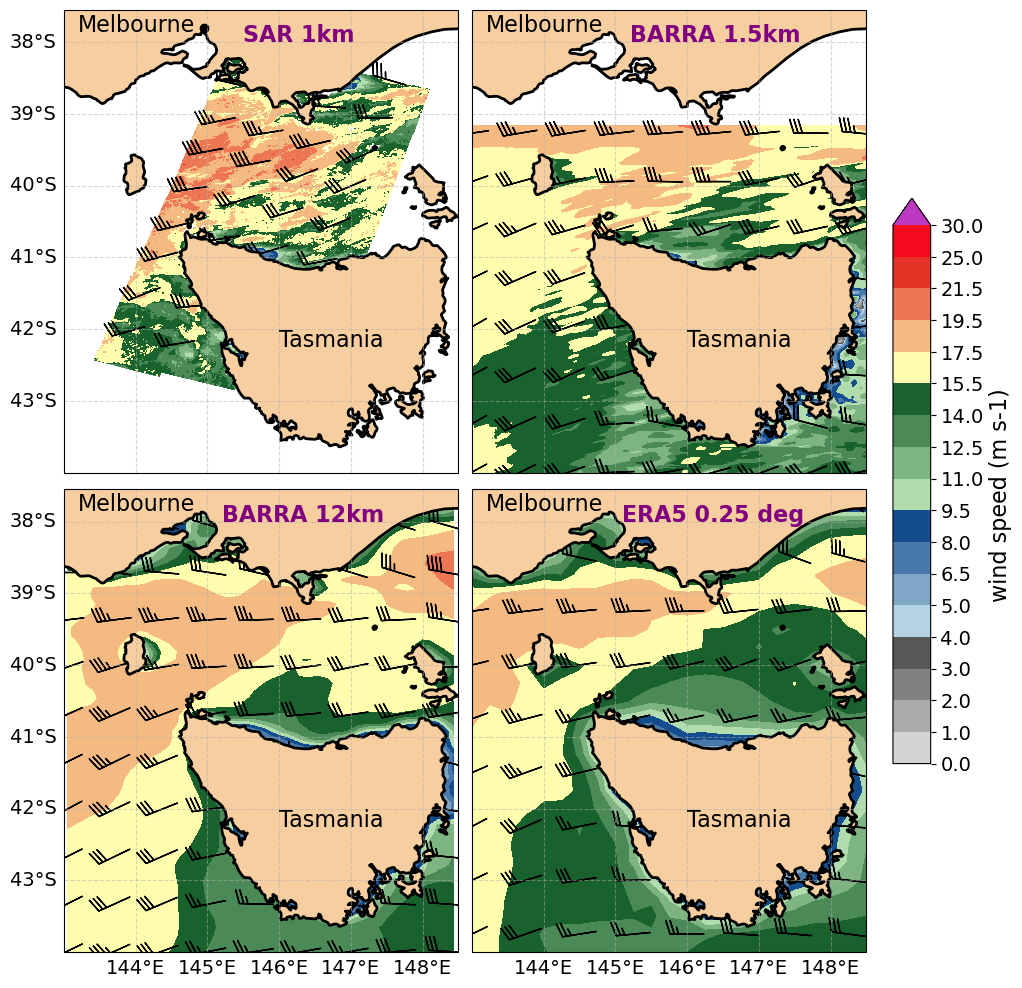

In [9]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (11, 10), 
                         subplot_kw = {'projection': cart.crs.PlateCarree()}, sharey = True)

# SAR wind map
ax = axes[0, 0]
land_10m = cfeature.NaturalEarthFeature('physical', 'land', '10m')
ax.add_feature(land_10m, edgecolor='k', facecolor = land_clr, linewidth = 2)
ax.add_feature(cfeature.STATES, linestyle = ':')
ax.plot(144.96, -37.81, 'ko')
ax.text(143.2, -37.85, 'Melbourne', fontsize = 16, color = 'black');
ax.text(146, -42.25, 'Tasmania', fontsize = 16, color = 'black');
ax.text(145.5, -38, 'SAR 1km', fontsize = 16, color = 'purple', fontweight = 'semibold');
ax.set_extent(extent)
# plot wind speed 
for dset in dset_list:
    cs = ax.contourf(dset['LONGITUDE'], dset['LATITUDE'], dset['WSPD_CAL'], 
                   levels = levels, transform = cart.crs.PlateCarree(), extend = 'max',
               colors = contour_clrs)    
gl = ax.gridlines(draw_labels = True, linestyle = '--', alpha = 0.5)
gl.top_labels = None
gl.right_labels = None
gl.bottom_labels = None
gl.xlabel_style = {'size': 14}
gl.ylabel_style = {'size': 14}
# add wind barbs
fact = 60
slc = slice(None, None, fact)
for dset in dset_list:
    uv = to_uv(dset['WSPD_CAL'] * mps2knots, met2math(dset['WDIR']))
    u = uv[0]
    v = uv[1]
    ax.barbs(dset['LONGITUDE'].isel(TIME = slc, RANGE = slc),
              dset['LATITUDE'].isel(TIME = slc, RANGE = slc), 
              u.isel(TIME = slc, RANGE = slc), 
              v.isel(TIME = slc, RANGE = slc),
              pivot = 'middle', transform = cart.crs.PlateCarree(), 
              color = 'k', rounding = True)    

# BARRA-Tas 1.5 km wind map
ax = axes[0, 1]
land_10m = cfeature.NaturalEarthFeature('physical', 'land', '10m')
ax.add_feature(land_10m, edgecolor='k', facecolor = land_clr, linewidth = 2)
ax.add_feature(cfeature.STATES, linestyle = ':')
ax.text(143.2, -37.85, 'Melbourne', fontsize = 16, color = 'black');
ax.text(146, -42.25, 'Tasmania', fontsize = 16, color = 'black');
ax.text(145.2, -38, 'BARRA 1.5km', fontsize = 16, color = 'purple', fontweight = 'semibold');
ax.set_extent(extent)
#plot wind speed
cs = ax.contourf(uwnd_ta['longitude'], uwnd_ta['latitude'], np.sqrt(uwnd_ta**2 + vwnd_ta**2), 
               levels = levels, transform = cart.crs.PlateCarree(), extend = 'max',
           colors = contour_clrs)    
gl = ax.gridlines(draw_labels = True, linestyle = '--', alpha = 0.5)
gl.top_labels = None
gl.right_labels = None
gl.bottom_labels = None
gl.left_labels = None
gl.xlabel_style = {'size': 14}
gl.ylabel_style = {'size': 14}

# add wind barbs
slc = slice(None, None, 50)
ax.barbs(uwnd_ta['longitude'].isel(longitude = slc),
         uwnd_ta['latitude'].isel(latitude = slc), 
         mps2knots*uwnd_ta.isel(longitude = slc, latitude = slc), 
         mps2knots*vwnd_ta.isel(longitude = slc, latitude = slc), 
         pivot = 'middle', transform = cart.crs.PlateCarree(), 
         color = 'k', rounding = True)

# BARRA-R 12 km wind map
ax = axes[1, 0]
land_10m = cfeature.NaturalEarthFeature('physical', 'land', '10m')
ax.add_feature(land_10m, edgecolor='k', facecolor = land_clr, linewidth = 2)
ax.add_feature(cfeature.STATES, linestyle = ':')
ax.text(143.2, -37.85, 'Melbourne', fontsize = 16, color = 'black');
ax.text(146, -42.25, 'Tasmania', fontsize = 16, color = 'black');
ax.text(145.2, -38, 'BARRA 12km', fontsize = 16, color = 'purple', fontweight = 'semibold');
ax.set_extent(extent)
#plot wind speed
cs = ax.contourf(uwnd_r['longitude'], uwnd_r['latitude'], np.sqrt(uwnd_r**2 + vwnd_r**2), 
               levels = levels, transform = cart.crs.PlateCarree(), extend = 'max',
           colors = contour_clrs)    
gl = ax.gridlines(draw_labels = True, linestyle = '--', alpha = 0.5)
gl.top_labels = None
gl.right_labels = None
gl.xlabel_style = {'size': 14}
gl.ylabel_style = {'size': 14}
# plot wind barbs
slc = slice(None, None, 6)
ax.barbs(uwnd_r['longitude'].isel(longitude = slc),
         uwnd_r['latitude'].isel(latitude = slc), 
         mps2knots*uwnd_r.isel(longitude = slc, latitude = slc), 
         mps2knots*vwnd_r.isel(longitude = slc, latitude = slc), 
         pivot = 'middle', transform = cart.crs.PlateCarree(), 
         color = 'k', rounding = True)   

# ERA5 0.25 deg wind map
ax = axes[1, 1]
land_10m = cfeature.NaturalEarthFeature('physical', 'land', '10m')
ax.add_feature(land_10m, edgecolor='k', facecolor = land_clr, linewidth = 2)
ax.add_feature(cfeature.STATES, linestyle = ':')
ax.text(143.2, -37.85, 'Melbourne', fontsize = 16, color = 'black');
ax.text(146, -42.25, 'Tasmania', fontsize = 16, color = 'black');
ax.text(145.1, -38, 'ERA5 0.25 deg', fontsize = 16, color = 'purple', fontweight = 'semibold');
ax.set_extent(extent)
# plot wind speed
cs = ax.contourf(u10_era5['longitude'], u10_era5['latitude'], np.sqrt(u10_era5**2 + v10_era5**2), 
               levels = levels, transform = cart.crs.PlateCarree(), extend = 'max',
           colors = contour_clrs)    
gl = ax.gridlines(draw_labels = True, linestyle = '--', alpha = 0.5)
gl.top_labels = None
gl.left_labels = None
gl.right_labels = None
gl.xlabel_style = {'size': 14}
gl.ylabel_style = {'size': 14}
# add wind barbs
slc = slice(None, None, 3)
ax.barbs(u10_era5['longitude'].isel(longitude = slc),
         u10_era5['latitude'].isel(latitude = slc), 
         mps2knots*u10_era5.isel(longitude = slc, latitude = slc), 
         mps2knots*v10_era5.isel(longitude = slc, latitude = slc), 
         pivot = 'middle', transform = cart.crs.PlateCarree(), 
         color = 'k', rounding = True)
fig.tight_layout();

# Add colorbar to figure
cbar = fig.colorbar(cs, ax = axes, orientation = 'vertical', 
         label = 'wind speed (m s-1)', aspect = 15,
         shrink = 0.6, pad = 0.025)
cbar.ax.tick_params(labelsize = 14)
cbar.set_label(label = 'wind speed (m s-1)', size = 16)
cbar.set_ticks(levels)
cbar.set_ticklabels(levels)
